In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
mass = 0.05
mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d[x,y,z,t]->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d[x,y,z,t] or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support

In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.179835114805142e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover.add_I(clover_term=clover_term), verbose=verbose, max_iter=200,max_levels=2)

self.dof_list:[12, 12, 12, 12, 8, 8, 4, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 8x8x8x8
  Level 1: 4x4x4x4
self.grid_list:[[8, 8, 8, 8], [4, 4, 4, 4]]
Norm of b:1.12115637175306
Norm of r:1.12115637175306
Norm of x0:0.0
BICGSTAB-Iteration 0: Residual = 1.929314e-01, Time = 0.011071 s
BICGSTAB-Iteration 1: Residual = 6.371150e-02, Time = 0.003266 s
BICGSTAB-Iteration 2: Residual = 1.329530e-01, Time = 0.003248 s
BICGSTAB-Iteration 3: Residual = 2.145065e-02, Time = 0.003214 s
BICGSTAB-Iteration 4: Residual = 1.614341e-02, Time = 0.003002 s
BICGSTAB-Iteration 5: Residual = 9.394413e-03, Time = 0.003295 s
BICGSTAB-Iteration 6: Residual = 6.988029e-03, Time = 0.002999 s
BICGSTAB-Iteration 7: Residual = 1.605667e-02, Time = 0.002925 s
BICGSTAB-Iteration 8: Residual = 6.915419e-03, Time = 0.002947 s
BICGSTAB-Iteration 9: Residual = 6.725968e-03, Time = 0.002914 s
BICGSTAB-Iteration 10: Residual = 3.368002e-03, Time = 0.002975 s
BICGSTAB-Iterat

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 6.18 ms, sys: 1.21 ms, total: 7.39 ms
Wall time: 6.62 ms
CPU times: user 1.81 ms, sys: 0 ns, total: 1.81 ms
Wall time: 1.73 ms
221.70250336881628
10.62561944948037
248.38478708613687
248.3847870861369
1.7520748139604143e-16
CPU times: user 28.4 ms, sys: 1.39 ms, total: 29.8 ms
Wall time: 28.8 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 3.01 ms
CPU times: user 1.36 ms, sys: 0 ns, total: 1.36 ms
Wall time: 1.23 ms


In [7]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)

Norm of b:221.3797633073902
Norm of r:332.7442554165274
Norm of x0:221.41449339488415
BICGSTAB-Iteration 0: Residual = 7.183947e+01, Time = 0.005905 s


BICGSTAB-Iteration 1: Residual = 3.026986e+01, Time = 0.004656 s
BICGSTAB-Iteration 2: Residual = 3.052723e+01, Time = 0.004448 s
BICGSTAB-Iteration 3: Residual = 2.063003e+01, Time = 0.004239 s
BICGSTAB-Iteration 4: Residual = 1.273302e+01, Time = 0.004249 s
BICGSTAB-Iteration 5: Residual = 9.926033e+00, Time = 0.003519 s
BICGSTAB-Iteration 6: Residual = 7.738278e+00, Time = 0.003059 s
BICGSTAB-Iteration 7: Residual = 1.900798e+01, Time = 0.002823 s
BICGSTAB-Iteration 8: Residual = 4.382611e+00, Time = 0.002791 s
BICGSTAB-Iteration 9: Residual = 5.613314e+00, Time = 0.002794 s
BICGSTAB-Iteration 10: Residual = 5.389500e+00, Time = 0.002857 s
BICGSTAB-Iteration 11: Residual = 4.895596e+00, Time = 0.002788 s
BICGSTAB-Iteration 12: Residual = 3.927878e+01, Time = 0.002868 s
BICGSTAB-Iteration 13: Residual = 1.186566e+01, Time = 0.002809 s
BICGSTAB-Iteration 14: Residual = 1.016425e+01, Time = 0.002877 s
BICGSTAB-Iteration 15: Residual = 7.885740e+00, Time = 0.002776 s
BICGSTAB-Iteration 

Norm of b:221.3797633073902
Norm of r:334.37554553826436
Norm of x0:222.05283536782224
restrict:shape,coarse_dof:(torch.Size([12, 12, 4, 2, 4, 2, 4, 2, 4, 2]), 12)
EeTtZzYyXx,eTtZzYyXx->ETZYX
Norm of b:31.421349535746046
Norm of r:31.421349535746046
Norm of x0:0.0
MG-1-BICGSTAB-Iteration 0: Residual = 3.902742e+01, Time = 0.002300 s
MG-1-BICGSTAB-Iteration 1: Residual = 6.862498e+01, Time = 0.003025 s
MG-1-BICGSTAB-Iteration 2: Residual = 2.524921e+01, Time = 0.003009 s
MG-1-BICGSTAB-Iteration 3: Residual = 2.743919e+02, Time = 0.003556 s
MG-1-BICGSTAB-Iteration 4: Residual = 2.119082e+01, Time = 0.002783 s
MG-1-BICGSTAB-Iteration 5: Residual = 2.617181e+02, Time = 0.002484 s
MG-1-BICGSTAB-Iteration 6: Residual = 1.964888e+01, Time = 0.002376 s
MG-1-BICGSTAB-Iteration 7: Residual = 8.640759e+01, Time = 0.002289 s
MG-1-BICGSTAB-Iteration 8: Residual = 1.201091e+01, Time = 0.002773 s
MG-1-BICGSTAB-Iteration 9: Residual = 1.333565e+01, Time = 0.003460 s
MG-1-BICGSTAB-Iteration 10: Residua

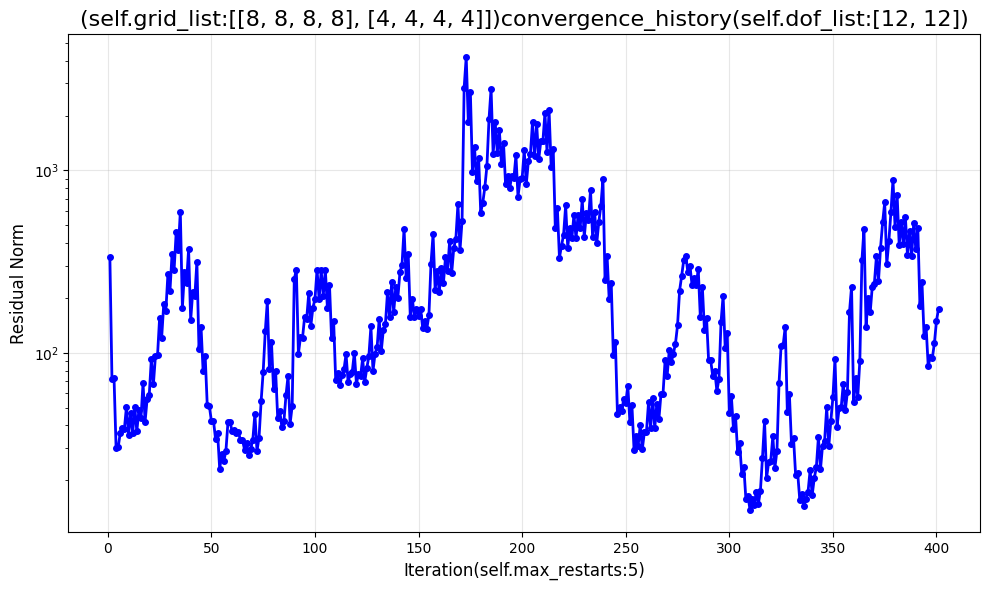

In [9]:
x = mg.solve()
mg.plot()

In [10]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 0.4269-6.7091e-01j, -0.1936-6.7814e-01j,  0.1356-3.0198e-01j,
        -0.1785-1.5005e-01j, -0.4715-1.2470e-01j, -0.4065-1.8240e-01j,
        -0.6593-7.4768e-01j, -0.3359-7.5532e-01j, -0.0744-7.4795e-01j,
        -0.0605-8.5516e-01j, -0.0594+1.0503e-01j,  0.2095-9.5405e-02j,
        -0.4256-1.5957e-01j, -0.4900-3.5709e-01j, -0.5453-5.0109e-01j,
        -0.3103-3.7855e-01j,  0.3274-1.2475e-01j, -0.7349+1.4385e-02j,
        -0.1029-8.3432e-02j, -0.5854-9.6909e-02j, -0.5601-7.1876e-01j,
        -0.6299-6.8715e-01j,  0.2411-5.9227e-01j,  0.2755-3.8173e-01j,
        -0.4398+1.4287e-01j, -0.1621+1.0083e-01j, -0.3860+2.7415e-01j,
        -0.2332-2.3554e-01j, -1.1996-2.5948e-01j, -0.5486-5.6399e-01j,
         0.2053-3.5067e-01j,  0.4540-3.6387e-01j, -0.0315-6.0768e-01j,
         0.0715-3.4945e-01j,  0.3177-1.4774e-01j, -0.2729+2.2243e-01j,
        -0.1271-1.9846e-01j, -0.4503+8.7433e-02j, -0.4305+3.1465e-02j,
        -0.6036-2.7181e-01j, -0.0675-5.1822e-01j,  0.2382-3.4262e-01j,
      

In [11]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

2.6761635940294894


In [12]:
mg.num_levels

2

In [13]:
index = -1
mg.u_list[-1] = inverse.bicgstab(b=torch.ones_like(mg.b_list[-1]),
                                 matvec=mg.op_list[-1].matvec, verbose=verbose,max_iter=10000)

Norm of b:55.42562584220407
Norm of r:157.93082602759097
Norm of x0:55.594670663712115
BICGSTAB-Iteration 0: Residual = 1.908756e+02, Time = 0.003027 s
BICGSTAB-Iteration 1: Residual = 1.529743e+02, Time = 0.002545 s
BICGSTAB-Iteration 2: Residual = 8.567830e+01, Time = 0.003162 s
BICGSTAB-Iteration 3: Residual = 8.458879e+01, Time = 0.004092 s
BICGSTAB-Iteration 4: Residual = 3.859513e+01, Time = 0.005701 s
BICGSTAB-Iteration 5: Residual = 1.965926e+02, Time = 0.006167 s
BICGSTAB-Iteration 6: Residual = 7.894073e+01, Time = 0.003575 s
BICGSTAB-Iteration 7: Residual = 2.936377e+01, Time = 0.002745 s
BICGSTAB-Iteration 8: Residual = 3.975068e+02, Time = 0.002336 s
BICGSTAB-Iteration 9: Residual = 2.592471e+01, Time = 0.002432 s
BICGSTAB-Iteration 10: Residual = 1.110409e+03, Time = 0.002082 s
BICGSTAB-Iteration 11: Residual = 2.423394e+01, Time = 0.002484 s
BICGSTAB-Iteration 12: Residual = 6.321759e+01, Time = 0.002007 s
BICGSTAB-Iteration 13: Residual = 1.744533e+01, Time = 0.001952 s